# Pretraining

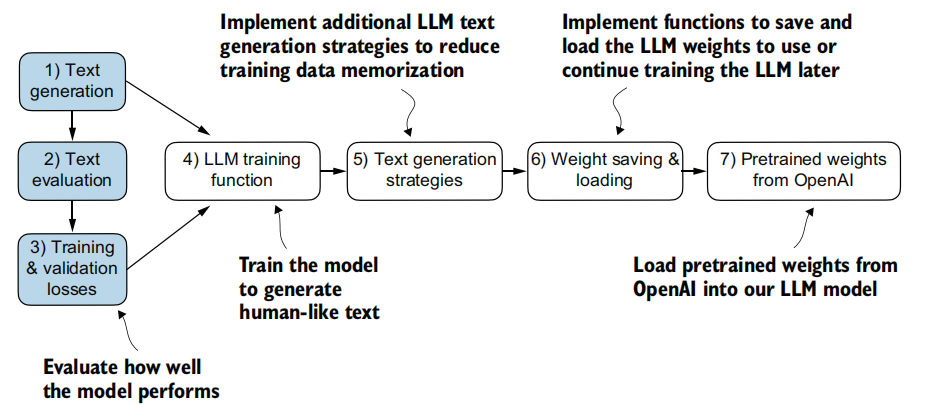

In [1]:
import torch
from gpt import GPTModel
GPT_CONFIG_124M = {
 "vocab_size": 50257,
 "context_length": 256, # We shorten the context length from 1,024 to 256 tokens. Original GPT-2 has a context length of 1,024 tokens.
 "emb_dim": 768,
 "n_heads": 12,
 "n_layers": 12, 
 "drop_rate": 0.1, 
 "qkv_bias": False
}
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## Utility functions for text to token ID conversion

In [2]:
import tiktoken
from gpt import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)   # Removes batch dimension
    return tokenizer.decode(flat.tolist())


In [3]:
# without pretraining
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


## Calculating the text generation loss

### Working of generate_text_simple function using an example of 7 words
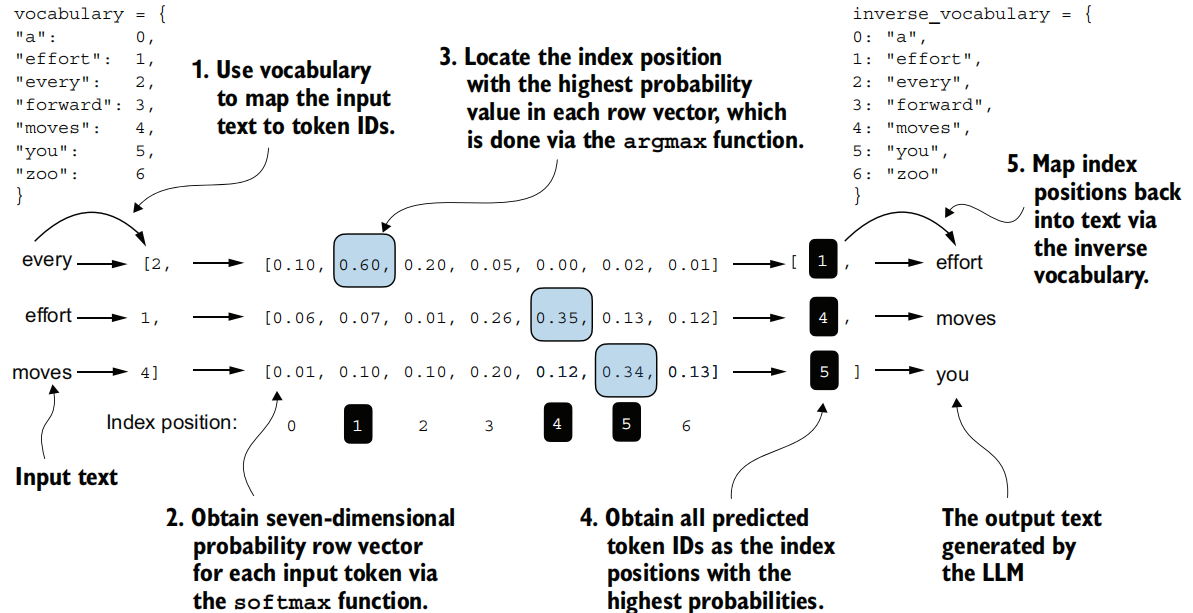

In [4]:
inputs = torch.tensor([[16833, 3626, 6100], # ["every effort moves",
                       [40, 1107, 588]])    # "I really like"]

In [5]:
targets = torch.tensor([[3626, 6100, 345 ], # [" effort moves you",
                        [1107, 588, 11311]]) # " really like chocolate"]

- Note that the targets are the inputs but shifted one position forward, a concept we
covered in chapter 2 during the implementation of the data loader.


- This shifting strategy is crucial for teaching the model to predict the next token in a sequence.

In [6]:
with torch.no_grad(): 
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1) 
print(probas.shape)

torch.Size([2, 3, 50257])


In [7]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [8]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}") # Batch-1 input
print(f"Outputs batch 1:"f" {token_ids_to_text(token_ids[0].flatten(), tokenizer)}") # Batch-1 output

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


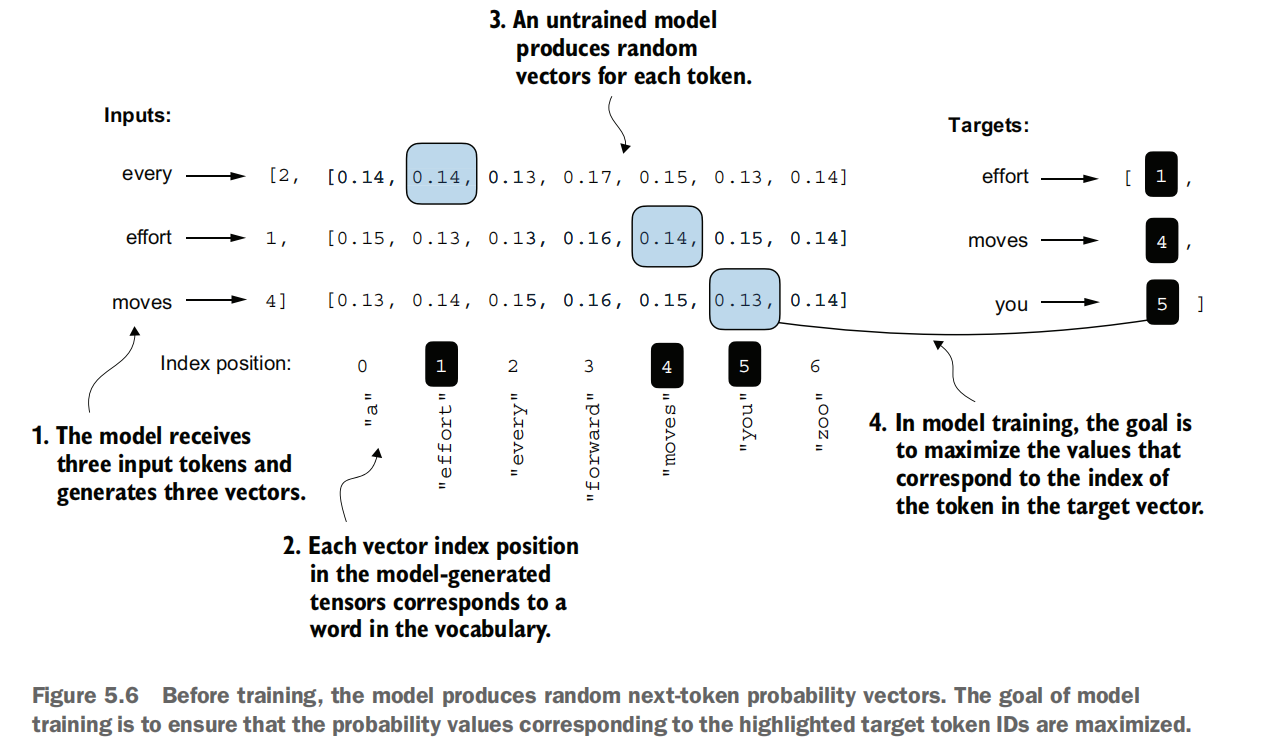

- For each of the two input texts, we can print the initial softmax probability scores corresponding to the target tokens using the following code

In [9]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)
text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- The goal of training an LLM is to maximize the likelihood of the correct token, which
involves increasing its probability relative to other tokens. 
- This way, we ensure the
LLM consistently picks the target token—essentially the next word in the sentence
as the next token it generates.

In [10]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [11]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(-10.7940)
tensor(10.7940)


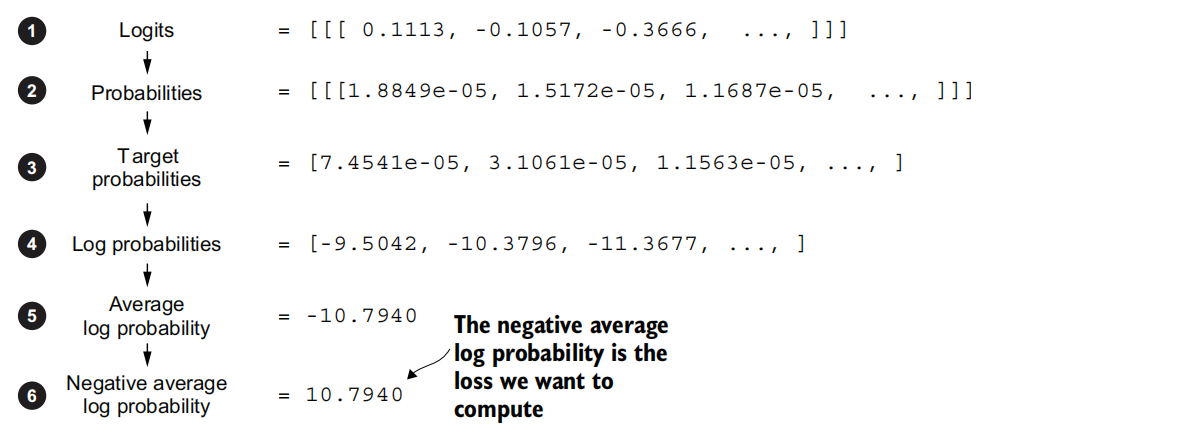

## Cross-Entropy Loss
- In the context of machine learning and specifically in frameworks like PyTorch, the
cross_entropy function computes this measure for discrete outcomes, which is
similar to the negative average log probability of the target tokens given the model’s
generated token probabilities, making the terms “cross entropy” and “negative average log probability” related and often used interchangeably in practice.

In [12]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [13]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


- Remember that the targets are the token IDs we want the LLM to generate, and the
logits contain the unscaled model outputs before they enter the softmax function to
obtain the probability scores.
- Previously, we applied the softmax function, selected the probability scores corresponding to the target IDs, and computed the negative average log probabilities.
PyTorch’s cross_entropy function will take care of all these steps for us:

In [14]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


## Perplexity

- Perplexity is a measure often used alongside cross entropy loss to evaluate the performance of models in tasks like language modeling. It can provide a more interpretable way to understand the uncertainty of a model in predicting the next token in a
sequence.


- Perplexity measures how well the probability distribution predicted by the model
matches the actual distribution of the words in the dataset. Similar to the loss, a lower
perplexity indicates that the model predictions are closer to the actual distribution.


- Perplexity is often considered more interpretable than the raw loss value because it signifies the effective vocabulary size about which the model is uncertain at each step. In
the given example, this would translate to the model being unsure about which among
48,725 tokens in the vocabulary to generate as the next token.

In [15]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


## Calculating the training and validation set losses

In [16]:
file_path = "../the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
 text_data = file.read()

In [17]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


## The train-val pipeline
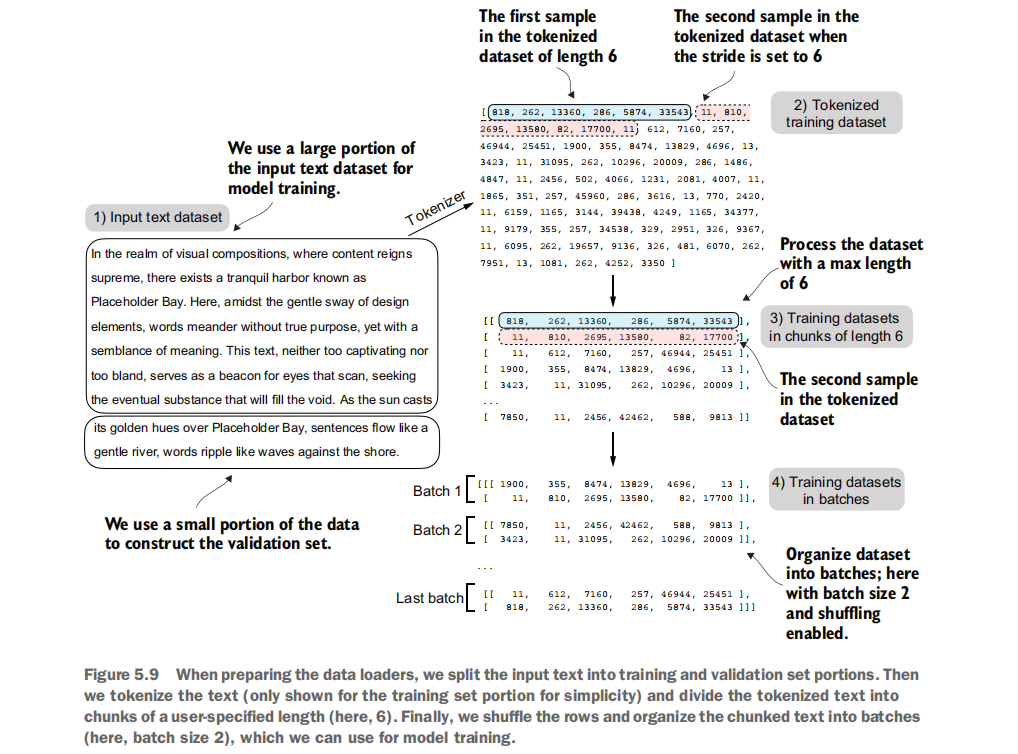

In [18]:
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [19]:
from data_loader import GPTDatasetV1
tokenizer = tiktoken.get_encoding("gpt2") 
dataset = GPTDatasetV1(text_data, tokenizer, 256, 256) 
dataset.__len__()

20

In [20]:
from data_loader import create_dataloader_v1

import tiktoken
tokenizer = tiktoken.get_encoding("gpt2") 

torch.manual_seed(123)
train_loader = create_dataloader_v1(
 train_data,
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=True,
 shuffle=True,
 num_workers=0
)
val_loader = create_dataloader_v1(
 val_data,
 batch_size=2,
 max_length=GPT_CONFIG_124M["context_length"],
 stride=GPT_CONFIG_124M["context_length"],
 drop_last=False,
 shuffle=False,
 num_workers=0
)

In [21]:
print("Train loader:")
for x, y in train_loader:
 print(x.shape, y.shape)
print("\nValidation loader:")
for x, y in val_loader:
 print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- Utility function to calculate the cross entropy loss of a given batch returned via the training and validation loader

In [22]:
def calc_loss_batch(input_batch, target_batch, model, device):
 input_batch = input_batch.to(device) 
 target_batch = target_batch.to(device) 
 logits = model(input_batch)
 loss = torch.nn.functional.cross_entropy(
    logits.flatten(0, 1), target_batch.flatten()
 )
 return loss

- By default, the calc_loss_loader function iterates over all batches in a given data
loader, accumulates the loss in the total_loss variable, and then computes and averages the loss over the total number of batches. Alternatively, we can specify a
smaller number of batches via num_batches to speed up the evaluation during model
training.

In [23]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) 
    else:
        num_batches = min(num_batches, len(data_loader)) 
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item() 
        else:
            break
    return total_loss / num_batches # Averages the loss over all batches

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) 
with torch.no_grad(): 
 train_loss = calc_loss_loader(train_loader, model, device) 
 val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583266364204
Validation loss: 10.981104850769043


# Training an LLM
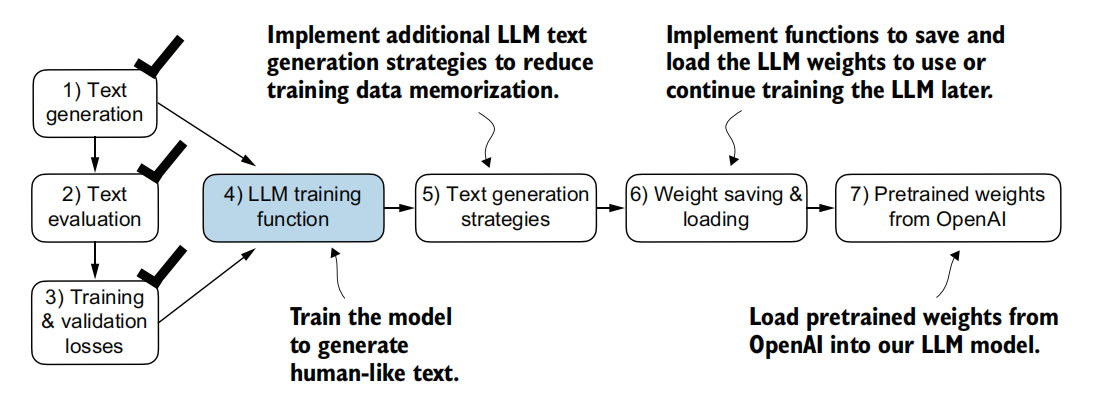

- The model train is similar to pytorch training pipeline

In [25]:
def train_model_simple(model, train_loader, val_loader,optimizer, device, num_epochs,eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []   # tracking losses and token seen
    tokens_seen, global_step = 0, -1
    for epoch in range(num_epochs): # Main training loop
        model.train()
        for input_batch, target_batch in train_loader: # this loop iterates in batches
            optimizer.zero_grad()           # reset loss gradient from previous batch iteration
            loss = calc_loss_batch(
                 input_batch, target_batch, model, device
            )
            loss.backward() # loss gradient
            optimizer.step() # update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1
            if global_step % eval_freq == 0: # Optional evaluation
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                f"Train loss {train_loss:.3f}, "
                f"Val loss {val_loss:.3f}")
        generate_and_print_sample(model, tokenizer, device, start_context)
    return train_losses, val_losses, track_tokens_seen

In [26]:
# Evaluating the validation losses
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()     # dropouts are disabled
    with torch.no_grad(): # disablibng the graddient tracking
        train_loss = calc_loss_loader(
                    train_loader, model, device, num_batches=eval_iter
            )
        val_loss = calc_loss_loader(
                     val_loader, model, device, num_batches=eval_iter
            )
    model.train()
    return train_loss, val_loss

In [27]:
# Generating and printing a sample text using the genearte_and_print_sample function
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
            )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " ")) 
    model.train()

- While the evaluate_model function gives us a numeric estimate of the model’s training progress, this generate_and_print_sample text function provides a concrete text
example generated by the model to judge its capabilities during training.

- Adam optimizers are a popular choice for training deep neural networks. However, in
our training loop, we opt for the AdamW optimizer. AdamW is a variant of Adam that
improves the weight decay approach, which aims to minimize model complexity and
prevent overfitting by penalizing larger weights. 

- This adjustment allows AdamW to
achieve more effective regularization and better generalization; thus, AdamW is frequently used in the training of LLMs.

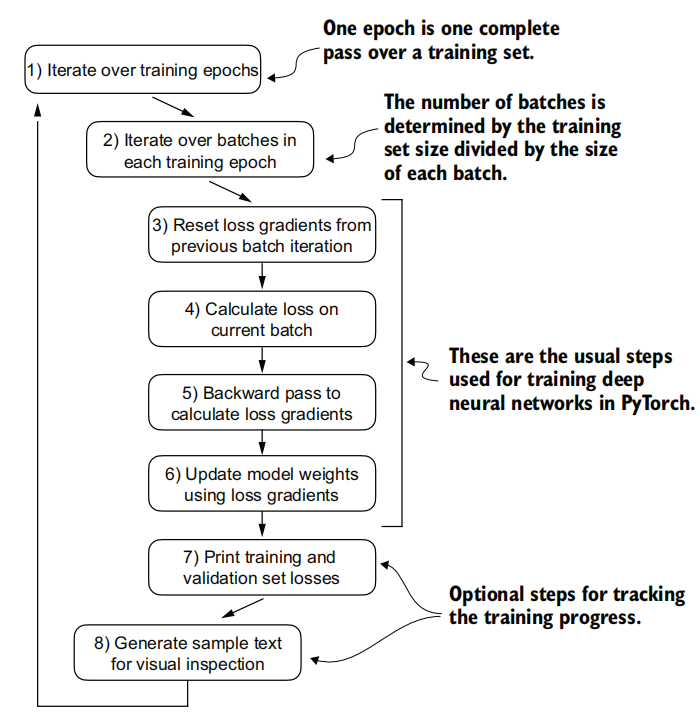

In [30]:
# Ready.... Set.... Go!
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="My name is Akshat shaw, I am a student at IIT Roorkee", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.823, Val loss 9.928
Ep 1 (Step 000005): Train loss 8.068, Val loss 8.336
My name is Akshat shaw, I am a student at IIT Roorkee,,,,,,,,,,,,,.                                    
Ep 2 (Step 000010): Train loss 6.620, Val loss 7.045
Ep 2 (Step 000015): Train loss 6.045, Val loss 6.600
My name is Akshat shaw, I am a student at IIT Roorkee, and, and,,,,, and, and,, and, and, and,,, and, and, the, and,,,,, and, and,,,, and, and,,,,, and
Ep 3 (Step 000020): Train loss 5.532, Val loss 6.496
Ep 3 (Step 000025): Train loss 5.412, Val loss 6.376
My name is Akshat shaw, I am a student at IIT Roorkee a. Gis, and, and, and, and, and I had the of the to the, and, and, and, and, and, and, and, and I had the, and, and, and, and, and
Ep 4 (Step 000030): Train loss 4.989, Val loss 6.307
Ep 4 (Step 000035): Train loss 4.612, Val loss 6.254
My name is Akshat shaw, I am a student at IIT Roorkee a.           "I"I had the                        "I had been.  
Ep 5 (Step 000040

In [31]:
generate_and_print_sample(model, tokenizer, device, "who is Gisburn")

who is Gisburn had never touched a brush."  "I told Mrs. Stroud so when she began to stammer something about her poverty. I remember getting off a prodigious phrase about the honour being _mine_--because he didn't want to


# Strategies to control randomness
- Temperature and Top-K Sampling

In [32]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [33]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




- The generated token is selected at each generation step corresponding to the largest probability score among all tokens in the vocabulary.
- This means that the LLM will always generate the same outputs even if we run the preceding generate_text_simple function multiple times on the same start context (Every
effort moves you).

## Temperature scaling
- To generate text with more variety,
we can replace argmax with a function that samples from a probability distribution
(here, the probability scores the LLM generates for each vocabulary entry at each
token generation step).

In [34]:
vocab = { 
 "closer": 0,
 "every": 1, 
 "effort": 2, 
 "forward": 3,
 "inches": 4,
 "moves": 5, 
 "pizza": 6,
 "toward": 7,
 "you": 8,
} 
inverse_vocab = {v: k for k, v in vocab.items()}

In [35]:
# let
next_token_logits = torch.tensor(
 [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)


In [36]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


- To implement a probabilistic sampling process, we can now replace argmax with
the multinomial function in PyTorch:

In [37]:
torch.manual_seed(123) 
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

toward


- The multinomial
function samples the next token proportional to its probability score. In other words,
"forward" is still the most likely token and will be selected by multinomial most of
the time but not all the time. To illustrate this, let’s implement a function that repeats
this sampling 1,000 times:

In [38]:
def print_sampled_tokens(probas):
 torch.manual_seed(123)
 sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
 sampled_ids = torch.bincount(torch.tensor(sample))
 for i, freq in enumerate(sampled_ids):
    print(f"{freq} x {inverse_vocab[i]}")
print_sampled_tokens(probas)

71 x closer
2 x every
0 x effort
544 x forward
2 x inches
1 x moves
0 x pizza
376 x toward
4 x you


- We can further control the distribution and selection process via a concept called
temperature scaling. Temperature scaling is just a fancy description for dividing the logits
by a number greater than 0:

In [39]:
def softmax_with_temperature(logits, temperature):
 scaled_logits = logits / temperature
 return torch.softmax(scaled_logits, dim=0)

- Temperatures greater than 1 result in more uniformly distributed token probabilities,
and temperatures smaller than 1 will result in more confident (sharper or more peaky)
distributions. Let’s illustrate this by plotting the original probabilities alongside probabilities scaled with different temperature values:

In [40]:
# There is some issue with the code below, the kernal dies when I run it. I am pasting the result from the book.

# temperatures = [1, 0.1, 5] 
# scaled_probas = [softmax_with_temperature(next_token_logits, T)
#  for T in temperatures]
# x = torch.arange(len(vocab))
# bar_width = 0.15
# fig, ax = plt.subplots(figsize=(5, 3))
# for i, T in enumerate(temperatures):
#  rects = ax.bar(x + i * bar_width, scaled_probas[i], 
#  bar_width, label=f'Temperature = {T}')
# ax.set_ylabel('Probability')
# ax.set_xticks(x)
# ax.set_xticklabels(vocab.keys(), rotation=90)
# ax.legend()
# plt.tight_layout()
# plt.show()

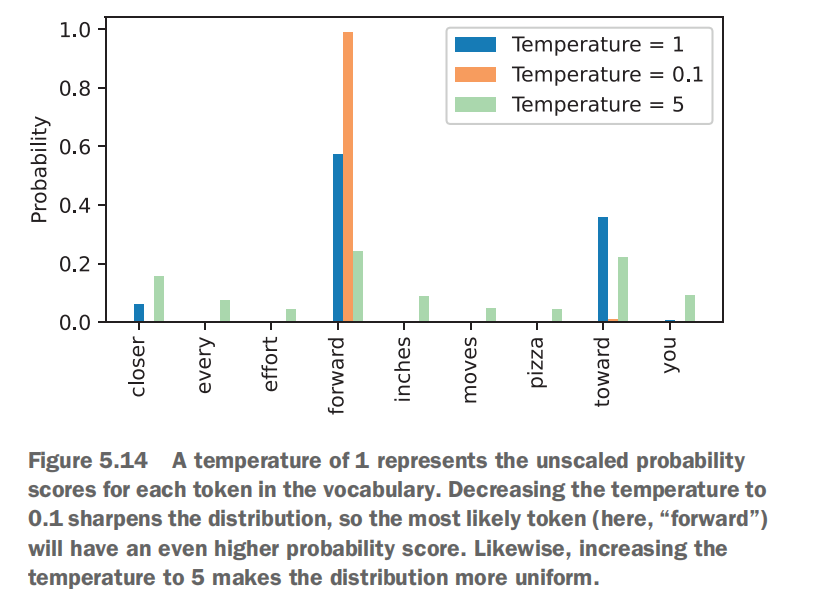

In [41]:
# excercise 5.1
def print_temp_token(probas, temperature):
 torch.manual_seed(123)
 probas = softmax_with_temperature(probas, temperature)
 sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
 sampled_ids = torch.bincount(torch.tensor(sample))
 for i, freq in enumerate(sampled_ids):
    print(f"{freq} x {inverse_vocab[i]}")
print_temp_token(probas, 0.5)

100 x closer
76 x every
102 x effort
226 x forward
90 x inches
84 x moves
78 x pizza
168 x toward
76 x you


# Top-k Sampling
- Top-k sampling, when combined with probabilistic sampling and temperature scaling, can improve the text generation results. In top-k sampling, we can restrict the
sampled tokens to the top-k most likely tokens and exclude all other tokens from the
selection process by masking their probability scores

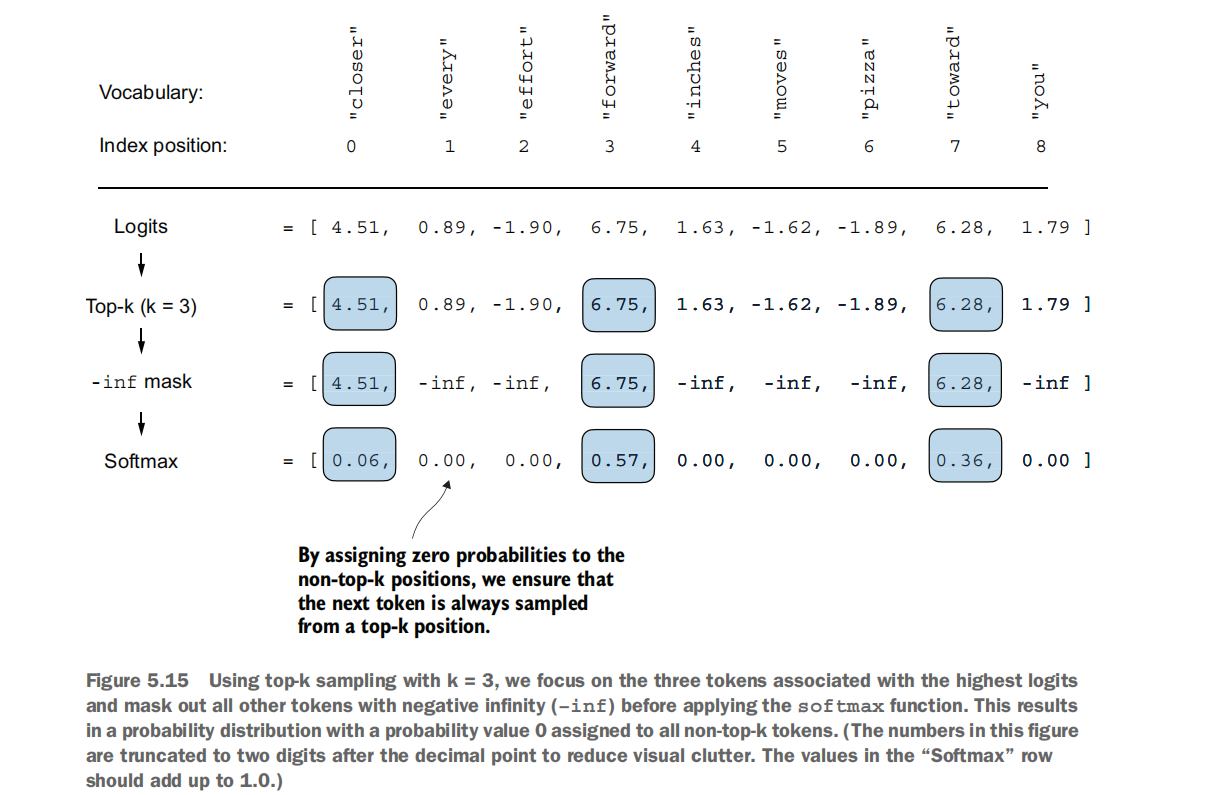

In [42]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k) # topk from torch
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [43]:
new_logits = torch.where(
 condition=next_token_logits < top_logits[-1], # Identifies logits less than the minimum in the top 3
 input=torch.tensor(float('-inf')),  # Assigns –inf to these lower logits
 other=next_token_logits # Retains the original logits for all other tokens
)
print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [44]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## Modifying the text generation function

In [45]:
# The final Generate function
# Note that if temperature is set to 0.0, the function will behave like argmax and Softmax will not be applied.

def generate(model, idx, max_new_tokens, context_size,
    temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens): # The for loop is the same as before: gets logits and only focuses on the last time step.
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
            logits = logits[:, -1, :]
            if top_k is not None: # filters logits to only consider the top-k tokens
                top_logits, _ = torch.topk(logits, top_k)
                min_val = top_logits[:, -1]
                logits = torch.where(
                    logits < min_val,
                    torch.tensor(float('-inf')).to(logits.device),
                    logits
                )
            if temperature > 0.0: # applies temperature scaling
                logits = logits / temperature
                probs = torch.softmax(logits, dim=-1)
                idx_next = torch.multinomial(probs, num_samples=1)
            else: 
                idx_next = torch.argmax(logits, dim=-1, keepdim=True)
            if idx_next == eos_id: # Stops generating early if end-of-sequence token is encountered
                break
            idx = torch.cat((idx, idx_next), dim=1)
    return idx

#### Let's try the model with improved generate logic

In [46]:
torch.manual_seed(123)
token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=10,
    temperature=0.7
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know began to go a little wild--I felt nervous and uncertain.

"Once, when I looked up, I


# Loading and saving model weights in PyTorch

- The recommended
way is to save a model’s state_dict, a dictionary mapping each layer to its parameters,
using the torch.save function:

In [47]:
torch.save(model.state_dict(), "akGPT-1.0.pth")

In [66]:
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("akGPT-1.0.pth", map_location=device))
model.eval()        

C:\Users\AKSHAT SHAW\AppData\Local\Temp\ipykernel_29588\3156326802.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("akGPT-1.0.pth", map_

<All keys matched successfully>

#### If we want to train the model later, we can also save the optimizer state.

In [ ]:
torch.save({
 "model_state_dict": model.state_dict(),
 "optimizer_state_dict": optimizer.state_dict(),
 }, 
 "akGPT-1.0.pth"
)

In [ ]:
checkpoint = torch.load("akGPT-1.0.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

# End of Notebook